In [11]:
!pip install torch_geometric
!pip install viennarna arnie forgi 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 6.4 MB/s eta 0:00:0000:0100:01m
  Preparing metadata (setup.py) ... done
  Created wheel for logging-exceptions: filename=logging_exceptions-0.1.9-py3-none-any.whl size=7943 sha256=f288fa6ded6acc7a846021d7874f75d5fa3fbf83975af18d84a708d34947c719
  Stored in directory: /root/.cache/pip/wheels/8b/55/70/ebbb68a1b48659a6af32232072356499ae47bfc95623bcd619
Successfully built logging-exceptions


In [ ]:
import torch
from torch.utils.data import random_split
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import polars as pl
import re
from tqdm import tqdm

In [ ]:
DATA_DIR = Path("/kaggle/input/stanford-ribonanza-rna-folding/")
TRAIN_CSV = DATA_DIR / "train_data.csv"
TRAIN_PARQUET_FILE = "train_data.parquet"
TEST_CSV = DATA_DIR / "test_sequences.csv"
TEST_PARQUET_FILE = "test_sequences.parquet"
PRED_CSV = "submission.csv"

## Convert to Parquet

Pandas is too slow, so the below converts the training and testing data to parquet. 

(((((.....(.((((..(((..........))).)))).))))))
GCUCCUAGAAAGGCGCGGGCCGAGGUACCAAGGCAGCGUGUGGAGC


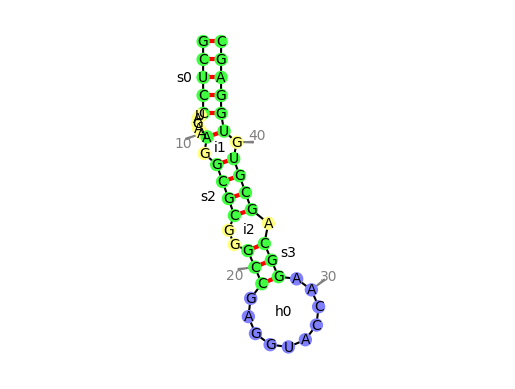

name rna1
length 46
seq GCUCCUAGAAAGGCGCGGGCCGAGGUACCAAGGCAGCGUGUGGAGC
seq_ids A:1 A:2 A:3 A:4 A:5 A:6 A:7 A:8 A:9 A:10 A:11 A:12 A:13 A:14 A:15 A:16 A:17 A:18 A:19 A:20 A:21 A:22 A:23 A:24 A:25 A:26 A:27 A:28 A:29 A:30 A:31 A:32 A:33 A:34 A:35 A:36 A:37 A:38 A:39 A:40 A:41 A:42 A:43 A:44 A:45 A:46
define s0 1 5 42 46
define i0 6 10
define s1 11 11 41 41
define i1 12 12 40 40
define s2 13 16 36 39
define i2 17 18 35 35
define s3 19 21 32 34
define h0 22 31
connect s0 i0
connect s1 i0 i1
connect s2 i1 i2
connect s3 i2 h0



In [34]:
import RNA
import forgi.graph.bulge_graph as fgb
import forgi.visual.mplotlib as fvm
import matplotlib.pyplot as plt
sequence = "GCUCCUAGAAAGGCGCGGGCCGAGGUACCAAGGCAGCGUGUGGAGC"

# compute minimum free energy (MFE) and corresponding structure
(structure, mfe) = RNA.fold(sequence)

# print output
#print("{}\n{} [ {:6.2f} ]".format(seq, structure, mfe))
print(ss)
print(sequence)
bg = fgb.BulgeGraph.from_fasta_text(f'>rna1\n{structure}\n{sequence}')[0]
#bg = fgb.BulgeGraph.from_dotbracket(ss)
fvm.plot_rna(bg, lighten=0.5, text_kwargs = {"fontweight":None})
plt.show();
print(bg.to_bg_string())

In [ ]:
def to_parquet(csv_file, parquet_file):
    dummy_df = pl.scan_csv(csv_file)

    new_schema = {}
    for key, value in dummy_df.schema.items():
        if key.startswith("reactivity"):
            new_schema[key] = pl.Float32
        else:
            new_schema[key] = value

    df = pl.scan_csv(csv_file, schema=new_schema)
    
    df.sink_parquet(
            parquet_file,
            compression='uncompressed',
            row_group_size=10,
    )

In [ ]:
to_parquet(TRAIN_CSV, TRAIN_PARQUET_FILE)
to_parquet(TEST_CSV, TEST_PARQUET_FILE)

## Define adjacency

Using ViennaRNAFolding, calculate the MSE graph representation of a sequence and construct an adjacency list of connections

In [ ]:
def nearest_adjacency(sequence_length, n=2, loops=True):
    base = np.arange(sequence_length)
    connections = []
    for i in range(-n, n + 1):
        if i == 0 and not loops:
            continue
        elif i == 0 and loops:
            stack = np.vstack([base, base])
            connections.append(stack)
            continue

        neighbours = base.take(range(i,sequence_length+i), mode='wrap')
        stack = np.vstack([base, neighbours])
        
        if i < 0:
            connections.append(stack[:, -i:])
        elif i > 0:
            connections.append(stack[:, :-i])

    return np.hstack(connections)

In [ ]:
EDGE_DISTANCE = 4

## Defining the dataloader. 

The below defines a simple dataloader that parses a parquet file into node embeddings (for now just the one hot encoded bases A, G, U and C), the adjacency (using the function above), and the targets (the reactivity scores). 

In [ ]:
class SimpleGraphDataset(Dataset):
    def __init__(self, parquet_name, edge_distance=5, root=None, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        # Set csv name
        self.parquet_name = parquet_name
        # Set edge distance
        self.edge_distance = edge_distance
        # Initialize one hot encoder
        self.node_encoder = OneHotEncoder(sparse_output=False, max_categories=5)
        # For one-hot encoder to possible values
        self.node_encoder.fit(np.array(['A', 'G', 'U', 'C']).reshape(-1, 1))
        # Load dataframe
        self.df = pl.read_parquet(self.parquet_name)
        self.df = self.df.filter(pl.col("SN_filter") == 1.0)
        # Get reactivity columns names
        reactivity_match = re.compile('(reactivity_[0-9])')
        reactivity_names = [col for col in self.df.columns if reactivity_match.match(col)]
        
        self.reactivity_df = self.df.select(reactivity_names) 

        self.sequence_df = self.df.select("sequence")

    def parse_row(self, idx):
        # Read row at idx
        sequence_row = self.sequence_df.row(idx)  
        reactivity_row = self.reactivity_df.row(idx)
        # Get sequence string and convert to array
        sequence = np.array(list(sequence_row[0])).reshape(-1, 1)
        # Encode sequence array
        encoded_sequence = self.node_encoder.transform(sequence)
        # Get sequence length
        sequence_length = len(sequence)
        # Get edge index 
        edges_np = nearest_adjacency(sequence_length, n=self.edge_distance, loops=False)
        # Convert to torch tensor
        edge_index = torch.tensor(edges_np, dtype=torch.long)

        # Get reactivity targets for nodes
        reactivity = np.array(reactivity_row, dtype=np.float32)[0:sequence_length]
     
        # Create valid masks for nodes
        valid_mask = np.argwhere(~np.isnan(reactivity)).reshape(-1)
        torch_valid_mask = torch.tensor(valid_mask, dtype=torch.long)

        # Replace nan values for reactivity with 0. 
        # Not actually super important as they get masked
        reactivity = np.nan_to_num(reactivity, copy=False, nan=0.0)


        # Define node features as one-hot encoded sequence
        node_features = torch.Tensor(encoded_sequence)

        # Targets 
        targets = torch.Tensor(reactivity)

        data = Data(x=node_features, edge_index=edge_index, y=targets, valid_mask=torch_valid_mask)

        return data

    def len(self):
        return len(self.df)

    def get(self, idx):
        data = self.parse_row(idx) 
        return data

## Data handling

Define the train and validation datasets, and load them with dataloaders. 

In [ ]:
full_train_dataset = SimpleGraphDataset(parquet_name=TRAIN_PARQUET_FILE, edge_distance=EDGE_DISTANCE)
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_train_dataset, [0.7, 0.3], generator1)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)

## Loss and metrics

Define the loss function and the MSE, and define the MAE as a loss. 

The target values are clipped to `(0, 1)` as the competition metric is. 

In [ ]:
import torch.nn.functional as F

def loss_fn(output, target):
    clipped_target = torch.clip(target, min=0, max=1)
    mses = F.mse_loss(output, clipped_target, reduction='mean')
    return mses

def mae_fn(output, target):
    clipped_target = torch.clip(target, min=0, max=1)
    maes = F.l1_loss(output, clipped_target, reduction='mean')
    return maes

## Define the model

Below we define as simple EdgeCNN from PyG. 
As a start, we give it 128 hidden channels, and 4 layers. 

In [ ]:
from torch_geometric.nn.models import EdgeCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EdgeCNN(in_channels=full_train_dataset.num_features, hidden_channels=128,
                num_layers=4, out_channels=1).to(device)

## Training 

Train the model for 10 epochs. 
Is this a good learning rate? 

In [ ]:
n_epochs = 10


optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=5e-4)


for epoch in range(n_epochs):
    train_losses = []
    train_maes = []
    model.train()
    for batch in (pbar := tqdm(train_dataloader, position=0, leave=True)):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        out = torch.squeeze(out)
        loss = loss_fn(out[batch.valid_mask], batch.y[batch.valid_mask])
        mae = mae_fn(out[batch.valid_mask], batch.y[batch.valid_mask])
        loss.backward()
        train_losses.append(loss.detach().cpu().numpy())
        train_maes.append(mae.detach().cpu().numpy())
        optimizer.step()
        pbar.set_description(f"Train loss {loss.detach().cpu().numpy():.4f}")       

    print(f"Epoch {epoch} train loss: ", np.mean(train_losses))    
    print(f"Epoch {epoch} train mae: ", np.mean(train_maes))    
    
    val_losses = []
    val_maes = []
    model.eval()
    for batch in (pbar := tqdm(val_dataloader, position=0, leave=True)):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        out = torch.squeeze(out)
        loss = loss_fn(out[batch.valid_mask], batch.y[batch.valid_mask])
        mae = mae_fn(out[batch.valid_mask], batch.y[batch.valid_mask])
        val_losses.append(loss.detach().cpu().numpy())
        val_maes.append(mae.detach().cpu().numpy())
        pbar.set_description(f"Validation loss {loss.detach().cpu().numpy():.4f}")      
        
    print(f"Epoch {epoch} val loss: ", np.mean(val_losses)) 
    print(f"Epoch {epoch} val mae: ", np.mean(val_maes))



In [ ]:
torch.cuda.empty_cache()

## Inference on the test set

Here we define a light weight dataset to handle the inference step. 

In [ ]:
class InferenceGraphDataset(Dataset):
    def __init__(self, parquet_name, edge_distance=2, root=None, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        # Set csv name
        self.parquet_name = parquet_name
        # Set edge distance
        self.edge_distance = edge_distance
        # Initialize one hot encoder
        self.node_encoder = OneHotEncoder(sparse_output=False, max_categories=4)
        # For one-hot encoder to possible values
        self.node_encoder.fit(np.array(['A', 'G', 'U', 'C']).reshape(-1, 1))
        # Load dataframe
        self.df = pl.read_parquet(self.parquet_name)

        self.sequence_df = self.df.select("sequence")
        self.id_min_df = self.df.select("id_min")

    def parse_row(self, idx):
        # Read row at idx
        sequence_row = self.sequence_df.row(idx)  
        id_min = self.id_min_df.row(idx)[0]

        # Get sequence string and convert to array
        sequence = np.array(list(sequence_row[0])).reshape(-1, 1)
        # Encode sequence array
        encoded_sequence = self.node_encoder.transform(sequence)
        # Get sequence length
        sequence_length = len(sequence)
        # Get edge index 
        edges_np = nearest_adjacency(sequence_length, n=self.edge_distance, loops=False)
        # Convert to torch tensor
        edge_index = torch.tensor(edges_np, dtype=torch.long)

        # Define node features as one-hot encoded sequence
        node_features = torch.Tensor(encoded_sequence)
        ids = torch.arange(id_min, id_min+sequence_length, 1)

        data = Data(x=node_features, edge_index=edge_index, ids=ids)

        return data

    def len(self):
        return len(self.df)

    def get(self, idx):
        data = self.parse_row(idx) 
        return data

In [ ]:
infer_dataset = InferenceGraphDataset(parquet_name=TEST_PARQUET_FILE, edge_distance=EDGE_DISTANCE)
infer_dataloader = DataLoader(infer_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval().to(device)

In [ ]:
ids = np.empty(shape = (0,1),dtype=int)
preds = np.empty(shape = (0,1),dtype=np.float32)


for batch in tqdm(infer_dataloader):
    batch = batch.to(device)
    out = model(batch.x, batch.edge_index).detach().cpu().numpy()

    ids = np.append(ids, batch.ids.detach().cpu().numpy())
    preds = np.append(preds, out)



## Submission

Create a csv file with the submission values. 
As you can see, I don't currently distinguish between `DMS_MaP` and `2A3_MaP`, so just write the same value to both. 

In [ ]:
submission_df = pl.DataFrame({"id": ids, "reactivity_DMS_MaP": preds, "reactivity_2A3_MaP": preds})

In [ ]:
submission_df.write_csv(PRED_CSV)

## Conclusion

This is a basic GNN "starter kit" that does the basics. 
There are many things that can be improved, but I hope this helps people get started. 